In [19]:
pip install shap

   ---------------------------------------- 0.0/530.3 kB ? eta -:--:--
   ------ --------------------------------- 81.9/530.3 kB 4.5 MB/s eta 0:00:01
   ---------------------------------------  522.2/530.3 kB 8.1 MB/s eta 0:00:01
   ---------------------------------------- 530.3/530.3 kB 6.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [15]:
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
from scipy.stats import linregress

In [16]:
# Configure logging
logging.basicConfig(
    filename='ml_pipeline.log',  # Log file
    level=logging.INFO,          # Log only INFO level and above
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format
)
logging.info("Script execution started.")

In [17]:
# Suppress warnings for clean output
warnings.filterwarnings("ignore")

In [18]:
# Ensure SHAP is properly imported
import shap
try:
    shap.initjs()
    logging.info("SHAP successfully initialized.")
except Exception as e:
    logging.error(f"Error initializing SHAP: {e}")

In [19]:
file_path = "MLE-Assignment.csv"  
df = pd.read_csv(file_path)

In [20]:
# Display basic info about the dataset
print("Dataset Overview:")
print(df.info())
print(df.head())
print(df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(449), object(1)
memory usage: 1.7+ MB
None
           hsi_id         0         1         2         3         4         5  \
0  imagoai_corn_0  0.416181  0.396844  0.408985  0.372865  0.385293  0.365390   
1  imagoai_corn_1  0.415797  0.402956  0.402564  0.396014  0.397192  0.389634   
2  imagoai_corn_2  0.389023  0.371206  0.373098  0.373872  0.361056  0.349709   
3  imagoai_corn_3  0.468837  0.473255  0.462949  0.459335  0.461672  0.459824   
4  imagoai_corn_4  0.483352  0.487274  0.469153  0.487648  0.464026  0.451152   

          6         7         8  ...       439       440       441       442  \
0  0.355226  0.343350  0.344837  ...  0.710280  0.717482  0.715078  0.705379   
1  0.375671  0.363689  0.373883  ...  0.684011  0.697271  0.701995  0.696077   
2  0.333882  0.330841  0.328925  ...  0.683054  0.669286  0.663179  0.676165  

In [21]:
# Check for missing values
total_missing = df.isnull().sum().sum()
print(f"Total missing values: {total_missing}")

Total missing values: 0


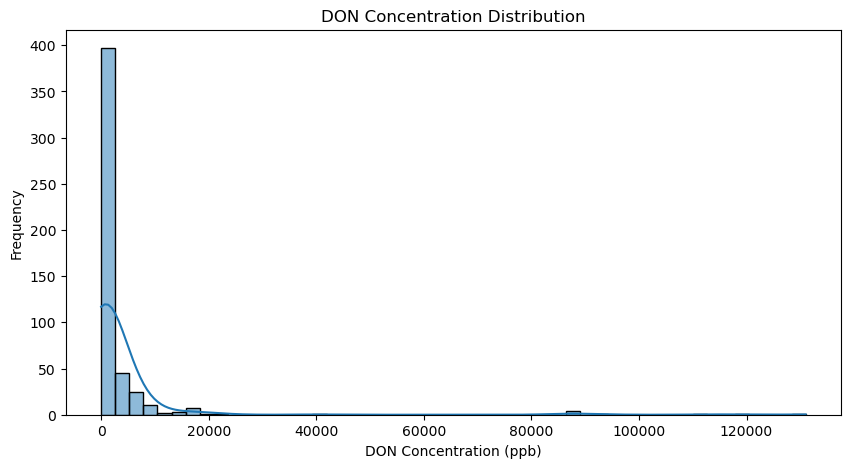

In [22]:
# Visualizing target variable distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["vomitoxin_ppb"], bins=50, kde=True)
plt.title("DON Concentration Distribution")
plt.xlabel("DON Concentration (ppb)")
plt.ylabel("Frequency")
plt.show()

In [23]:
# Apply log transformation to normalize skewed target variable
df["vomitoxin_ppb_log"] = np.log1p(df["vomitoxin_ppb"])

In [24]:
# Extract wavelength columns (Assuming wavelengths are in specific columns)
wavelength_columns = df.columns[1:-2]  

In [25]:
# Compute mean reflectance
avg_reflectance = df[wavelength_columns].mean()

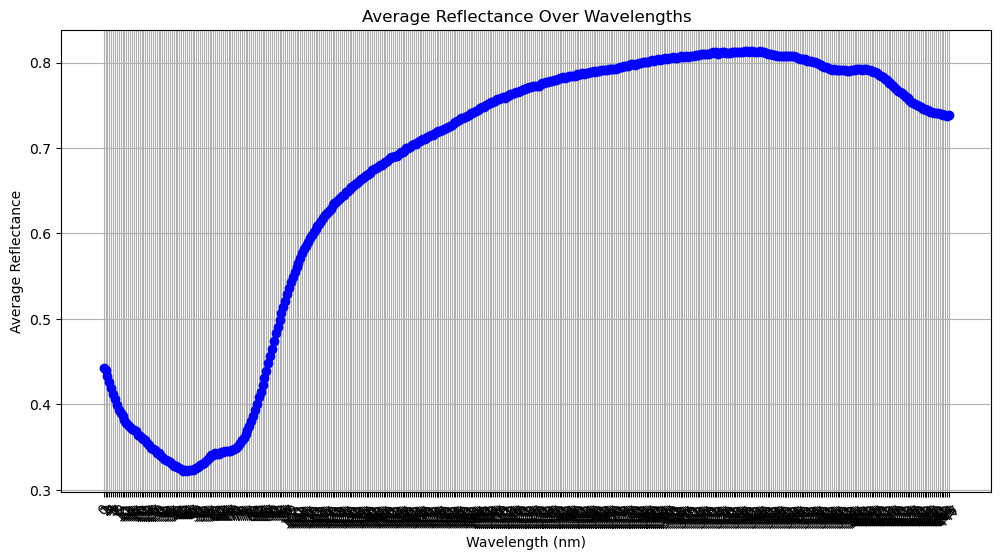

In [26]:
# Line plot
plt.figure(figsize=(12, 6))
plt.plot(wavelength_columns, avg_reflectance, marker='o', linestyle='-', color='b')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Average Reflectance")
plt.title("Average Reflectance Over Wavelengths")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [27]:
# Subset first 50 samples for better visualization
sample_data = df[wavelength_columns].iloc[:50]

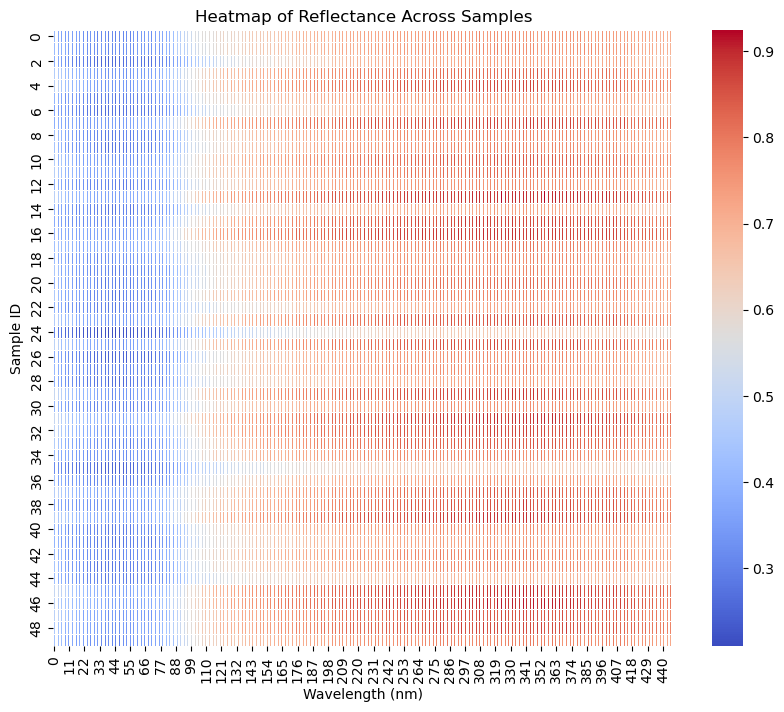

In [28]:
# Generate heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sample_data, cmap="coolwarm", linewidths=0.5)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Sample ID")
plt.title("Heatmap of Reflectance Across Samples")
plt.show()

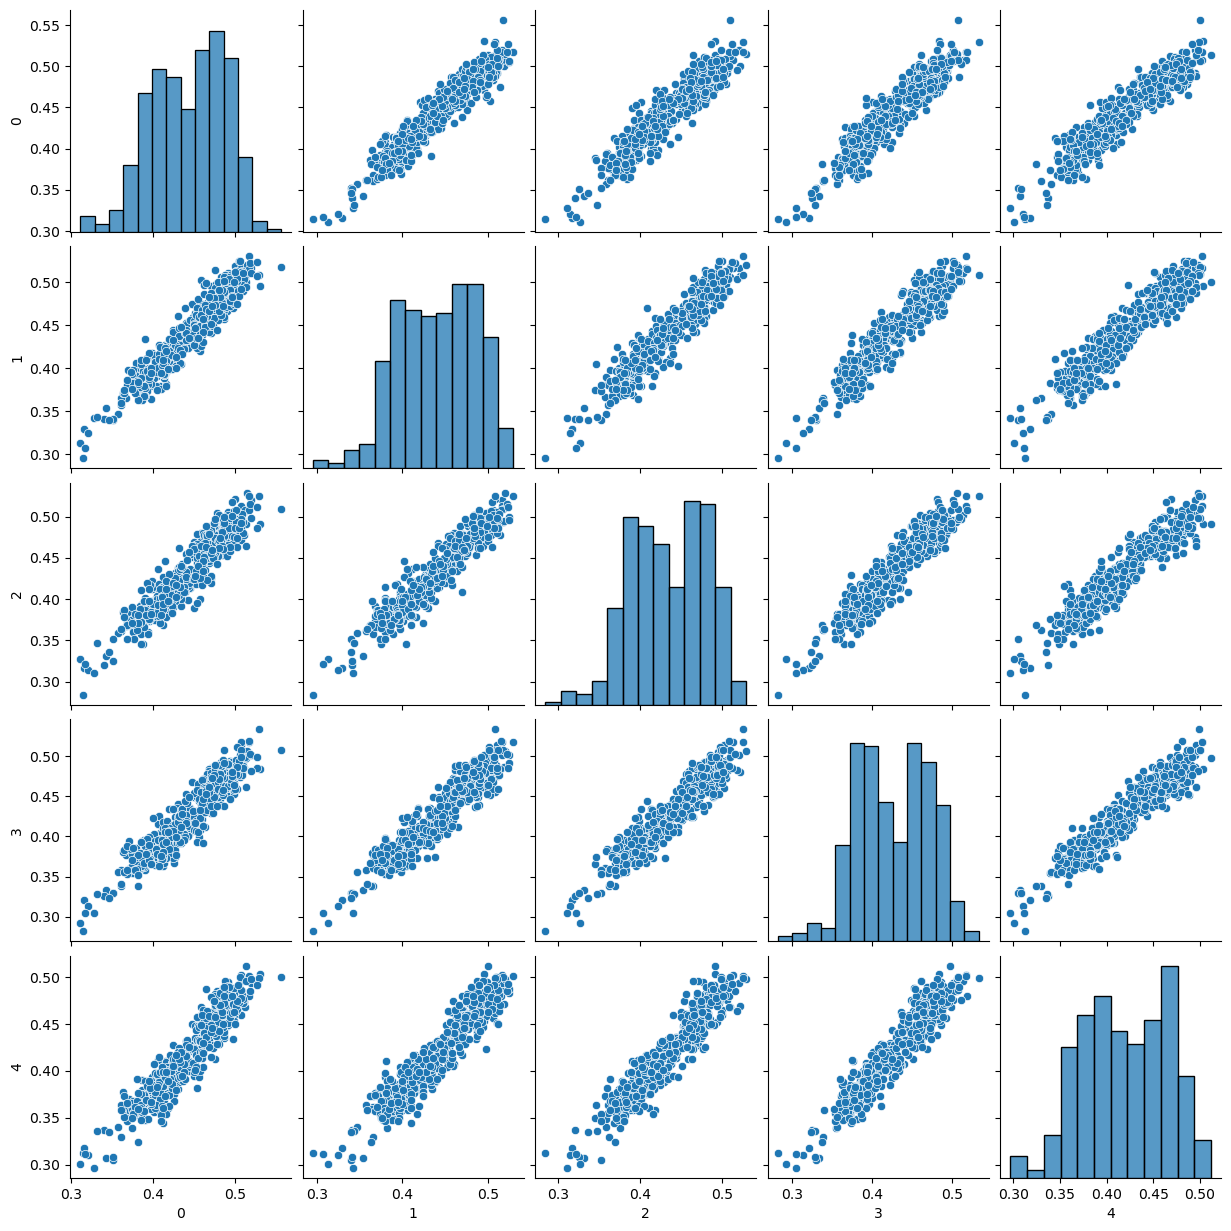

In [29]:
# subset of wavelengths for pairplot (Too many columns can be overwhelming)
selected_wavelengths = wavelength_columns[:5]  # First 5 wavelengths for simplicity


sns.pairplot(df[selected_wavelengths])
plt.show()

In [30]:
# Identify wavelength columns (assuming they are in a specific range)
wavelength_columns = df.columns[1:-2]

In [31]:
# Compute rolling mean for sensor drift detection
window_size = 20  # Adjust based on dataset
rolling_means = df[wavelength_columns].rolling(window=window_size).mean()


In [32]:
# Compute standard deviation over time
rolling_std = df[wavelength_columns].rolling(window=window_size).std()

In [33]:
# Detect trends in sensor readings using linear regression
drift_results = {}
for wave in wavelength_columns:
    slope, intercept, r_value, p_value, std_err = linregress(range(len(df)), df[wave])
    drift_results[wave] = slope  # Slope indicates increasing or decreasing trend

In [34]:
# Identify wavelengths with significant drift
drift_df = pd.DataFrame(list(drift_results.items()), columns=["Wavelength", "Slope"])
drift_threshold = 0.01  # Define an acceptable threshold
drifting_wavelengths = drift_df[abs(drift_df["Slope"]) > drift_threshold]

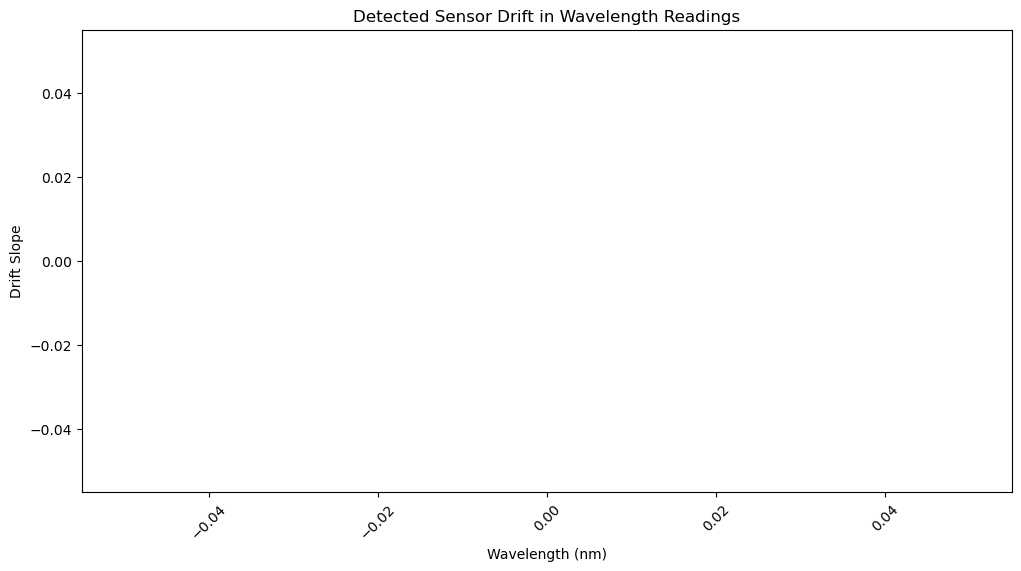

⚠️ Wavelengths showing potential sensor drift:
Empty DataFrame
Columns: [Wavelength, Slope]
Index: []


In [35]:
# Plot drift results
plt.figure(figsize=(12, 6))
plt.bar(drifting_wavelengths["Wavelength"], drifting_wavelengths["Slope"], color='r')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Drift Slope")
plt.title("Detected Sensor Drift in Wavelength Readings")
plt.xticks(rotation=45)
plt.show()

print(f"⚠️ Wavelengths showing potential sensor drift:\n{drifting_wavelengths}")

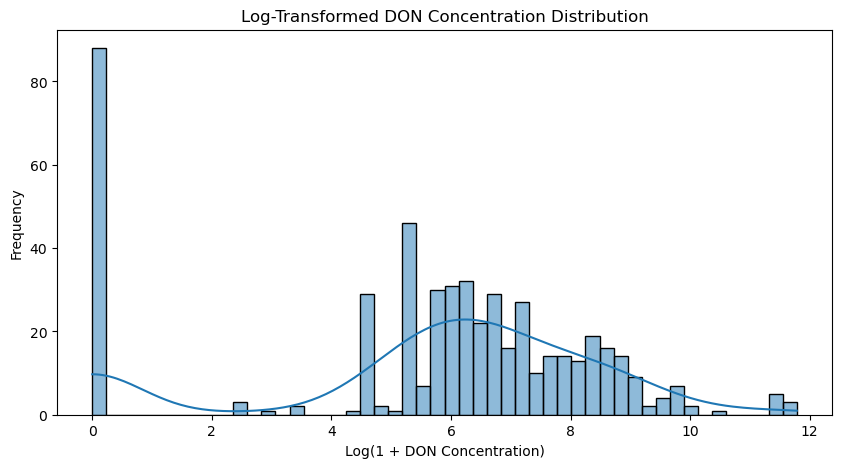

In [36]:
# Re-plot distribution after transformation
plt.figure(figsize=(10, 5))
sns.histplot(df["vomitoxin_ppb_log"], bins=50, kde=True)
plt.title("Log-Transformed DON Concentration Distribution")
plt.xlabel("Log(1 + DON Concentration)")
plt.ylabel("Frequency")
plt.show()

In [37]:
# Re-plot distribution after transformation
X = df.iloc[:, 1:-2]  
y = df["vomitoxin_ppb_log"]

In [38]:
# Re-plot distribution after transformation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [40]:
# Define and train a simple neural network model
model = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=500, random_state=42)
model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)

In [41]:
# Generate predictions
y_pred = model.predict(X_test)

In [42]:
# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [43]:
print("Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Model Performance:
Mean Absolute Error (MAE): 2.3654
Root Mean Squared Error (RMSE): 3.1269
R² Score: -0.2044


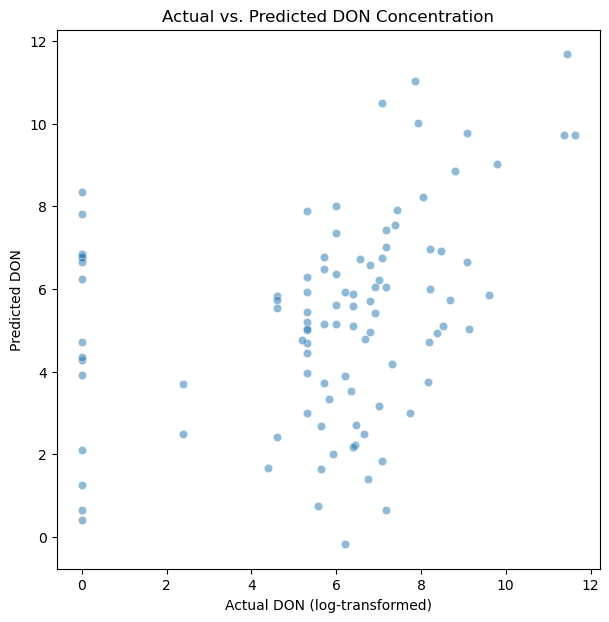

In [44]:
# Scatter plot to visualize prediction accuracy
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Actual DON (log-transformed)")
plt.ylabel("Predicted DON")
plt.title("Actual vs. Predicted DON Concentration")
plt.show()

In [50]:
# SHAP Analysis with adjusted explainer to avoid max_evals issue

try: 
    num_features = X_train.shape[1]
    min_evals = 2 * num_features + 1
    logging.info(f"Number of features: {num_features}, Computed min_evals: {min_evals}")
except Exception as e:
    logging.error(f"Error computing num_features and min_evals: {e}")
    raise

In [46]:
explainer = shap.Explainer(model.predict, X_train[:100], max_evals=min_evals) 
shap_values = explainer(X_test[:100])  


PermutationExplainer explainer: 101it [01:05,  1.34it/s]                         


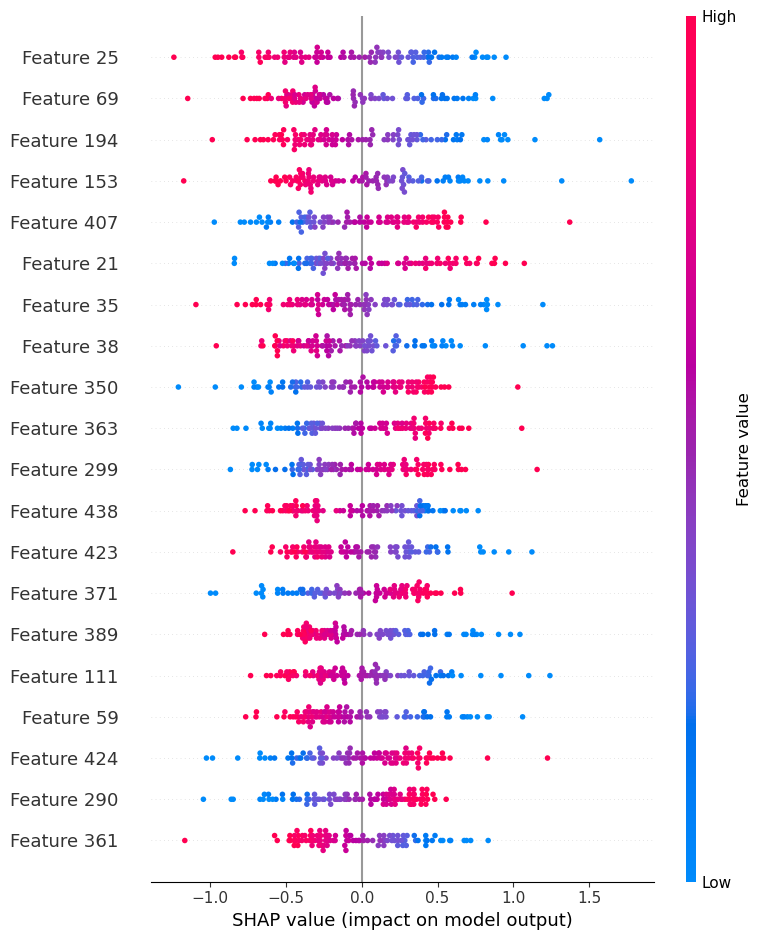

In [47]:
# Summary plot for SHAP values
shap.summary_plot(shap_values, X_test[:100])

UNIT TESTING

In [48]:
import unittest

class TestExample(unittest.TestCase):
    def test_sample(self):
        self.assertEqual(2 + 2, 4)  # Simple test

if __name__ == "__main__":
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


.
----------------------------------------------------------------------
Ran 1 test in 0.011s

OK


In [49]:
unittest.main(argv=['first-arg-is-ignored'], exit=False)


.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK
